In [1]:
import numpy as np
import nnfs
import os
import cv2
import pickle
import copy

nnfs.init()


# Dense layer
class Layer_Dense:

	# Layer initialization
	def __init__(self, n_inputs, n_neurons,
				 weight_regularizer_l1=0, weight_regularizer_l2=0,
				 bias_regularizer_l1=0, bias_regularizer_l2=0):
		# Initialize weights and biases
		self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
		self.biases = np.zeros((1, n_neurons))
		# Set regularization strength
		self.weight_regularizer_l1 = weight_regularizer_l1
		self.weight_regularizer_l2 = weight_regularizer_l2
		self.bias_regularizer_l1 = bias_regularizer_l1
		self.bias_regularizer_l2 = bias_regularizer_l2

	# Forward pass
	def forward(self, inputs, training):
		# Remember input values
		self.inputs = inputs
		# Calculate output values from inputs, weights and biases
		self.output = np.dot(inputs, self.weights) + self.biases

	# Backward pass
	def backward(self, dvalues):
		# Gradients on parameters
		self.dweights = np.dot(self.inputs.T, dvalues)
		self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


		# Gradients on regularization
		# L1 on weights
		if self.weight_regularizer_l1 > 0:
			dL1 = np.ones_like(self.weights)
			dL1[self.weights < 0] = -1
			self.dweights += self.weight_regularizer_l1 * dL1
		# L2 on weights
		if self.weight_regularizer_l2 > 0:
			self.dweights += 2 * self.weight_regularizer_l2 * \
							 self.weights
		# L1 on biases
		if self.bias_regularizer_l1 > 0:
			dL1 = np.ones_like(self.biases)
			dL1[self.biases < 0] = -1
			self.dbiases += self.bias_regularizer_l1 * dL1
		# L2 on biases
		if self.bias_regularizer_l2 > 0:
			self.dbiases += 2 * self.bias_regularizer_l2 * \
							self.biases

		# Gradient on values
		self.dinputs = np.dot(dvalues, self.weights.T)

	# Retrieve layer parameters
	def get_parameters(self):
		return self.weights, self.biases

	# Set weights and biases in a layer instance
	def set_parameters(self, weights, biases):
		self.weights = weights
		self.biases = biases


# ReLU activation
class Activation_ReLU:

	# Forward pass
	def forward(self, inputs, training):
		# Remember input values
		self.inputs = inputs
		# Calculate output values from inputs
		self.output = np.maximum(0, inputs)

	# Backward pass
	def backward(self, dvalues):
		# Since we need to modify original variable,
		# let's make a copy of values first
		self.dinputs = dvalues.copy()

		# Zero gradient where input values were negative
		self.dinputs[self.inputs <= 0] = 0

	# Calculate predictions for outputs
	def predictions(self, outputs):
		return outputs



# Softmax activation
class Activation_Softmax:

	# Forward pass
	def forward(self, inputs, training):
		# Remember input values
		self.inputs = inputs

		# Get unnormalized probabilities
		exp_values = np.exp(inputs - np.max(inputs, axis=1,
											keepdims=True))
		# Normalize them for each sample
		probabilities = exp_values / np.sum(exp_values, axis=1,
											keepdims=True)

		self.output = probabilities

	# Backward pass
	def backward(self, dvalues):

		# Create uninitialized array
		self.dinputs = np.empty_like(dvalues)

		# Enumerate outputs and gradients
		for index, (single_output, single_dvalues) in \
				enumerate(zip(self.output, dvalues)):
			# Flatten output array
			single_output = single_output.reshape(-1, 1)
			# Calculate Jacobian matrix of the output
			jacobian_matrix = np.diagflat(single_output) - \
							  np.dot(single_output, single_output.T)
			# Calculate sample-wise gradient
			# and add it to the array of sample gradients
			self.dinputs[index] = np.dot(jacobian_matrix,
										 single_dvalues)

	# Calculate predictions for outputs
	def predictions(self, outputs):
		return np.argmax(outputs, axis=1)




# Adam optimizer
class Optimizer_Adam:

	# Initialize optimizer - set settings
	def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
				 beta_1=0.9, beta_2=0.999):
		self.learning_rate = learning_rate
		self.current_learning_rate = learning_rate
		self.decay = decay
		self.iterations = 0
		self.epsilon = epsilon
		self.beta_1 = beta_1
		self.beta_2 = beta_2

	# Call once before any parameter updates
	def pre_update_params(self):
		if self.decay:
			self.current_learning_rate = self.learning_rate * \
				(1. / (1. + self.decay * self.iterations))

	# Update parameters
	def update_params(self, layer):

		# If layer does not contain cache arrays,
		# create them filled with zeros
		if not hasattr(layer, 'weight_cache'):
			layer.weight_momentums = np.zeros_like(layer.weights)
			layer.weight_cache = np.zeros_like(layer.weights)
			layer.bias_momentums = np.zeros_like(layer.biases)
			layer.bias_cache = np.zeros_like(layer.biases)


		# Update momentum  with current gradients
		layer.weight_momentums = self.beta_1 * \
								 layer.weight_momentums + \
								 (1 - self.beta_1) * layer.dweights
		layer.bias_momentums = self.beta_1 * \
							   layer.bias_momentums + \
							   (1 - self.beta_1) * layer.dbiases
		# Get corrected momentum
		# self.iteration is 0 at first pass
		# and we need to start with 1 here
		weight_momentums_corrected = layer.weight_momentums / \
			(1 - self.beta_1 ** (self.iterations + 1))
		bias_momentums_corrected = layer.bias_momentums / \
			(1 - self.beta_1 ** (self.iterations + 1))
		# Update cache with squared current gradients
		layer.weight_cache = self.beta_2 * layer.weight_cache + \
			(1 - self.beta_2) * layer.dweights**2
		layer.bias_cache = self.beta_2 * layer.bias_cache + \
			(1 - self.beta_2) * layer.dbiases**2
		# Get corrected cache
		weight_cache_corrected = layer.weight_cache / \
			(1 - self.beta_2 ** (self.iterations + 1))
		bias_cache_corrected = layer.bias_cache / \
			(1 - self.beta_2 ** (self.iterations + 1))

		# Vanilla SGD parameter update + normalization
		# with square rooted cache
		layer.weights += -self.current_learning_rate * \
						 weight_momentums_corrected / \
						 (np.sqrt(weight_cache_corrected) +
							 self.epsilon)
		layer.biases += -self.current_learning_rate * \
						 bias_momentums_corrected / \
						 (np.sqrt(bias_cache_corrected) +
							 self.epsilon)

	# Call once after any parameter updates
	def post_update_params(self):
		self.iterations += 1



# Common loss class
class Loss:

	# Regularization loss calculation
	def regularization_loss(self):

		# 0 by default
		regularization_loss = 0

		# Calculate regularization loss
		# iterate all trainable layers
		for layer in self.trainable_layers:

			# L1 regularization - weights
			# calculate only when factor greater than 0
			if layer.weight_regularizer_l1 > 0:
				regularization_loss += layer.weight_regularizer_l1 * \
									   np.sum(np.abs(layer.weights))

			# L2 regularization - weights
			if layer.weight_regularizer_l2 > 0:
				regularization_loss += layer.weight_regularizer_l2 * \
									   np.sum(layer.weights * \
											  layer.weights)

			# L1 regularization - biases
			# calculate only when factor greater than 0
			if layer.bias_regularizer_l1 > 0:
				regularization_loss += layer.bias_regularizer_l1 * \
									   np.sum(np.abs(layer.biases))

			# L2 regularization - biases
			if layer.bias_regularizer_l2 > 0:
				regularization_loss += layer.bias_regularizer_l2 * \
									   np.sum(layer.biases * \
											  layer.biases)

		return regularization_loss

	# Set/remember trainable layers
	def remember_trainable_layers(self, trainable_layers):
		self.trainable_layers = trainable_layers


	# Calculates the data and regularization losses
	# given model output and ground truth values
	def calculate(self, output, y, *, include_regularization=False):

		# Calculate sample losses
		sample_losses = self.forward(output, y)

		# Calculate mean loss
		data_loss = np.mean(sample_losses)

		# Add accumulated sum of losses and sample count
		self.accumulated_sum += np.sum(sample_losses)
		self.accumulated_count += len(sample_losses)

		# If just data loss - return it
		if not include_regularization:
			return data_loss

		# Return the data and regularization losses
		return data_loss, self.regularization_loss()

	# Calculates accumulated loss
	def calculate_accumulated(self, *, include_regularization=False):

		# Calculate mean loss
		data_loss = self.accumulated_sum / self.accumulated_count

		# If just data loss - return it
		if not include_regularization:
			return data_loss

		# Return the data and regularization losses
		return data_loss, self.regularization_loss()

	# Reset variables for accumulated loss
	def new_pass(self):
		self.accumulated_sum = 0
		self.accumulated_count = 0



# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):  # L2 loss

	# Forward pass
	def forward(self, y_pred, y_true):

		# Calculate loss
		sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

		# Return losses
		return sample_losses

	# Backward pass
	def backward(self, dvalues, y_true):

		# Number of samples
		samples = len(dvalues)
		# Number of outputs in every sample
		# We'll use the first sample to count them
		outputs = len(dvalues[0])

		# Gradient on values
		self.dinputs = -2 * (y_true - dvalues) / outputs
		# Normalize gradient
		self.dinputs = self.dinputs / samples


# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss):  # L1 loss

	def forward(self, y_pred, y_true):

		# Calculate loss
		sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

		# Return losses
		return sample_losses


	# Backward pass
	def backward(self, dvalues, y_true):

		# Number of samples
		samples = len(dvalues)
		# Number of outputs in every sample
		# We'll use the first sample to count them
		outputs = len(dvalues[0])

		# Calculate gradient
		self.dinputs = np.sign(y_true - dvalues) / outputs
		# Normalize gradient
		self.dinputs = self.dinputs / samples


# Common accuracy class
class Accuracy:

	# Calculates an accuracy
	# given predictions and ground truth values
	def calculate(self, predictions, y):

		# Get comparison results
		comparisons = self.compare(predictions, y)

		# Calculate an accuracy
		accuracy = np.mean(comparisons)

		# Add accumulated sum of matching values and sample count
		self.accumulated_sum += np.sum(comparisons)
		self.accumulated_count += len(comparisons)

		# Return accuracy
		return accuracy

	# Calculates accumulated accuracy
	def calculate_accumulated(self):

		# Calculate an accuracy
		accuracy = self.accumulated_sum / self.accumulated_count

		# Return the data and regularization losses
		return accuracy

	# Reset variables for accumulated accuracy
	def new_pass(self):
		self.accumulated_sum = 0
		self.accumulated_count = 0



# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

	def __init__(self, *, binary=False):
		# Binary mode?
		self.binary = binary

	# No initialization is needed
	def init(self, y):
		pass

	# Compares predictions to the ground truth values
	def compare(self, predictions, y):
		if not self.binary and len(y.shape) == 2:
			y = np.argmax(y, axis=1)
		return predictions == y


# Accuracy calculation for regression model
class Accuracy_Regression(Accuracy):

	def __init__(self):
		# Create precision property
		self.precision = None

	# Calculates precision value
	# based on passed-in ground truth values
	def init(self, y, reinit=False):
		if self.precision is None or reinit:
			self.precision = np.std(y) / 250

	# Compares predictions to the ground truth values
	def compare(self, predictions, y):
		return np.absolute(predictions - y) < self.precision


# Model class
class Model:

	def __init__(self):
		# Create a list of network objects
		self.layers = []
		# Softmax classifier's output object
		self.softmax_classifier_output = None

	# Add objects to the model
	def add(self, layer):
		self.layers.append(layer)


	# Set loss, optimizer and accuracy
	def set(self, *, loss=None, optimizer=None, accuracy=None):

		if loss is not None:
			self.loss = loss

		if optimizer is not None:
			self.optimizer = optimizer

		if accuracy is not None:
			self.accuracy = accuracy

	# Finalize the model
	def finalize(self):

		# Create and set the input layer
		self.input_layer = Layer_Input()

		# Count all the objects
		layer_count = len(self.layers)

		# Initialize a list containing trainable layers:
		self.trainable_layers = []

		# Iterate the objects
		for i in range(layer_count):

			# If it's the first layer,
			# the previous layer object is the input layer
			if i == 0:
				self.layers[i].prev = self.input_layer
				self.layers[i].next = self.layers[i+1]

			# All layers except for the first and the last
			elif i < layer_count - 1:
				self.layers[i].prev = self.layers[i-1]
				self.layers[i].next = self.layers[i+1]

			# The last layer - the next object is the loss
			# Also let's save aside the reference to the last object
			# whose output is the model's output
			else:
				self.layers[i].prev = self.layers[i-1]
				self.layers[i].next = self.loss
				self.output_layer_activation = self.layers[i]


			# If layer contains an attribute called "weights",
			# it's a trainable layer -
			# add it to the list of trainable layers
			# We don't need to check for biases -
			# checking for weights is enough
			if hasattr(self.layers[i], 'weights'):
				self.trainable_layers.append(self.layers[i])

		# Update loss object with trainable layers
		if self.loss is not None:
			print(self.trainable_layers)
			self.loss.remember_trainable_layers(self.trainable_layers)

		# If output activation is Softmax and
		# loss function is Categorical Cross-Entropy
		# create an object of combined activation
		# and loss function containing
		# faster gradient calculation

	# Train the model
	def train(self, X, y, *, epochs=1, batch_size=None,
			  print_every=1, validation_data=None):

		# Initialize accuracy object
		self.accuracy.init(y)

		# Default value if batch size is not being set
		train_steps = 1

		# Calculate number of steps
		if batch_size is not None:
			train_steps = len(X) // batch_size
			# Dividing rounds down. If there are some remaining
			# data but not a full batch, this won't include it
			# Add `1` to include this not full batch
			if train_steps * batch_size < len(X):
				train_steps += 1


		# Main training loop
		for epoch in range(1, epochs+1):

			# Print epoch number
			print(f'epoch: {epoch}')

			# Reset accumulated values in loss and accuracy objects
			self.loss.new_pass()
			self.accuracy.new_pass()

			# Iterate over steps
			for step in range(train_steps):

				# If batch size is not set -
				# train using one step and full dataset
				if batch_size is None:
					batch_X = X
					batch_y = y

				# Otherwise slice a batch
				else:
					batch_X = X[step*batch_size:(step+1)*batch_size]
					batch_y = y[step*batch_size:(step+1)*batch_size]

				# Perform the forward pass
				output = self.forward(batch_X, training=True)

				# Calculate loss
				data_loss, regularization_loss = \
					self.loss.calculate(output, batch_y,
										include_regularization=True)
				loss = data_loss + regularization_loss

				# Get predictions and calculate an accuracy
				predictions = self.output_layer_activation.predictions(
								  output)
				accuracy = self.accuracy.calculate(predictions,
												   batch_y)

				# Perform backward pass
				self.backward(output, batch_y)

				# Optimize (update parameters)
				self.optimizer.pre_update_params()
				for layer in self.trainable_layers:
					self.optimizer.update_params(layer)
				self.optimizer.post_update_params()


				# Print a summary
				if not step % print_every or step == train_steps - 1:
					print(f'step: {step}, ' +
						  f'acc: {accuracy:.3f}, ' +
						  f'loss: {loss:.3f} (' +
						  f'data_loss: {data_loss:.3f}, ' +
						  f'reg_loss: {regularization_loss:.3f}), ' +
						  f'lr: {self.optimizer.current_learning_rate}')

			# Get and print epoch loss and accuracy
			epoch_data_loss, epoch_regularization_loss = \
				self.loss.calculate_accumulated(
					include_regularization=True)
			epoch_loss = epoch_data_loss + epoch_regularization_loss
			epoch_accuracy = self.accuracy.calculate_accumulated()

			print(f'training, ' +
				  f'acc: {epoch_accuracy:.3f}, ' +
				  f'loss: {epoch_loss:.3f} (' +
				  f'data_loss: {epoch_data_loss:.3f}, ' +
				  f'reg_loss: {epoch_regularization_loss:.3f}), ' +
				  f'lr: {self.optimizer.current_learning_rate}')

			# If there is the validation data
			if validation_data is not None:

				# Evaluate the model:
				self.evaluate(*validation_data,
							  batch_size=batch_size)

	# Evaluates the model using passed-in dataset
	def evaluate(self, X_val, y_val, *, batch_size=None):

		# Default value if batch size is not being set
		validation_steps = 1

		# Calculate number of steps
		if batch_size is not None:
			validation_steps = len(X_val) // batch_size
			# Dividing rounds down. If there are some remaining
			# data but not a full batch, this won't include it
			# Add `1` to include this not full batch
			if validation_steps * batch_size < len(X_val):
				validation_steps += 1

		# Reset accumulated values in loss
		# and accuracy objects
		self.loss.new_pass()
		self.accuracy.new_pass()


		# Iterate over steps
		for step in range(validation_steps):

			# If batch size is not set -
			# train using one step and full dataset
			if batch_size is None:
				batch_X = X_val
				batch_y = y_val

			# Otherwise slice a batch
			else:
				batch_X = X_val[
					step*batch_size:(step+1)*batch_size
				]
				batch_y = y_val[
					step*batch_size:(step+1)*batch_size
				]

			# Perform the forward pass
			output = self.forward(batch_X, training=False)

			# Calculate the loss
			self.loss.calculate(output, batch_y)

			# Get predictions and calculate an accuracy
			predictions = self.output_layer_activation.predictions(
							  output)
			self.accuracy.calculate(predictions, batch_y)

		# Get and print validation loss and accuracy
		validation_loss = self.loss.calculate_accumulated()
		validation_accuracy = self.accuracy.calculate_accumulated()

		# Print a summary
		print(f'validation, ' +
			  f'acc: {validation_accuracy:.3f}, ' +
			  f'loss: {validation_loss:.3f}')

	# Predicts on the samples
	def predict(self, X, *, batch_size=None):

		# Default value if batch size is not being set
		prediction_steps = 1

		# Calculate number of steps
		if batch_size is not None:
			prediction_steps = len(X) // batch_size

			# Dividing rounds down. If there are some remaining
			# data but not a full batch, this won't include it
			# Add `1` to include this not full batch
			if prediction_steps * batch_size < len(X):
				prediction_steps += 1

		# Model outputs
		output = []

		# Iterate over steps
		for step in range(prediction_steps):

			# If batch size is not set -
			# train using one step and full dataset
			if batch_size is None:
				batch_X = X

			# Otherwise slice a batch
			else:
				batch_X = X[step*batch_size:(step+1)*batch_size]

			# Perform the forward pass
			batch_output = self.forward(batch_X, training=False)

			# Append batch prediction to the list of predictions
			output.append(batch_output)

		# Stack and return results
		return np.vstack(output)

	# Performs forward pass
	def forward(self, X, training):

		# Call forward method on the input layer
		# this will set the output property that
		# the first layer in "prev" object is expecting
		self.input_layer.forward(X, training)

		# Call forward method of every object in a chain
		# Pass output of the previous object as a parameter
		for layer in self.layers:
			layer.forward(layer.prev.output, training)

		# "layer" is now the last object from the list,
		# return its output
		return layer.output


	# Performs backward pass
	def backward(self, output, y):

		# If softmax classifier
		if self.softmax_classifier_output is not None:
			# First call backward method
			# on the combined activation/loss
			# this will set dinputs property
			self.softmax_classifier_output.backward(output, y)

			# Since we'll not call backward method of the last layer
			# which is Softmax activation
			# as we used combined activation/loss
			# object, let's set dinputs in this object
			self.layers[-1].dinputs = \
				self.softmax_classifier_output.dinputs

			# Call backward method going through
			# all the objects but last
			# in reversed order passing dinputs as a parameter
			for layer in reversed(self.layers[:-1]):
				layer.backward(layer.next.dinputs)

			return

		# First call backward method on the loss
		# this will set dinputs property that the last
		# layer will try to access shortly
		self.loss.backward(output, y)

		# Call backward method going through all the objects
		# in reversed order passing dinputs as a parameter
		for layer in reversed(self.layers):
			layer.backward(layer.next.dinputs)

	# Retrieves and returns parameters of trainable layers
	def get_parameters(self):

		# Create a list for parameters
		parameters = []

		# Iterable trainable layers and get their parameters
		for layer in self.trainable_layers:
			parameters.append(layer.get_parameters())

		# Return a list
		return parameters


	# Updates the model with new parameters
	def set_parameters(self, parameters):

		# Iterate over the parameters and layers
		# and update each layers with each set of the parameters
		for parameter_set, layer in zip(parameters,
										self.trainable_layers):
			layer.set_parameters(*parameter_set)

	# Saves the parameters to a file
	def save_parameters(self, path):

		# Open a file in the binary-write mode
		# and save parameters into it
		with open(path, 'wb') as f:
			pickle.dump(self.get_parameters(), f)

	# Loads the weights and updates a model instance with them
	def load_parameters(self, path):

		# Open file in the binary-read mode,
		# load weights and update trainable layers
		with open(path, 'rb') as f:
			self.set_parameters(pickle.load(f))

	# Saves the model
	def save(self, path):

		# Make a deep copy of current model instance
		model = copy.deepcopy(self)

		# Reset accumulated values in loss and accuracy objects
		model.loss.new_pass()
		model.accuracy.new_pass()

		# Remove data from the input layer
		# and gradients from the loss object
		model.input_layer.__dict__.pop('output', None)
		model.loss.__dict__.pop('dinputs', None)

		# For each layer remove inputs, output and dinputs properties
		for layer in model.layers:
			for property in ['inputs', 'output', 'dinputs',
							 'dweights', 'dbiases']:
				layer.__dict__.pop(property, None)

		# Open a file in the binary-write mode and save the model
		with open(path, 'wb') as f:
			pickle.dump(model, f)


	# Loads and returns a model
	@staticmethod
	def load(path):

		# Open file in the binary-read mode, load a model
		with open(path, 'rb') as f:
			model = pickle.load(f)

		# Return a model
		return model




In [2]:
# Input "layer"
class Layer_Input:

	# Forward pass
	def forward(self, inputs, training):
		self.output = inputs

	def backward(self, dvalues):
		self.dinputs = dvalues


In [3]:
model = Model()
model.add(Layer_Input())
model.add(Layer_Dense(1, 256))
model.add(Activation_ReLU())
model.add(Layer_Dense(256, 1))
model.add(Activation_Softmax())

model.set(loss=Loss_MeanAbsoluteError(),optimizer=Optimizer_Adam(), accuracy=Accuracy_Regression())
model.finalize()

[<__main__.Layer_Dense object at 0x7f35e82d9e50>, <__main__.Layer_Dense object at 0x7f35e82d9d00>]


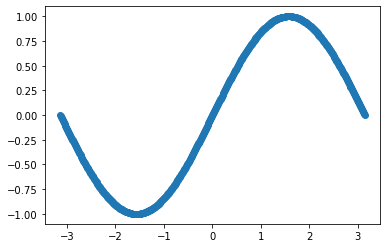

In [4]:
import matplotlib.pyplot as plt
def train_function(x):
    return x, np.sin(x)
# define input sequence
xaxis = np.arange(-1*np.pi, 1*np.pi, 0.01)
ax_test = np.arange(8*np.pi, 10*np.pi, 0.01)
X,y = train_function(xaxis)
X_test,y_test = train_function(ax_test)
X = np.array([X])
plt.scatter(X,y)

In [5]:
X = np.reshape(X, (-1, 1))
y = np.reshape(y, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X.shape)
print(y.shape)

(629, 1)
(629, 1)


In [6]:
model.train(X, y, epochs=500)

epoch: 1
step: 0, acc: 0.003, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
training, acc: 2.000, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
epoch: 2
step: 0, acc: 0.003, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
training, acc: 2.000, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
epoch: 3
step: 0, acc: 0.003, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
training, acc: 2.000, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
epoch: 4
step: 0, acc: 0.003, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
training, acc: 2.000, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
epoch: 5
step: 0, acc: 0.003, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
training, acc: 2.000, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
epoch: 6
step: 0, acc: 0.003, loss: 1.000 (data_loss: 1.000, reg_loss: 0.000), lr: 0.001
training, acc: 2.000, loss: 1.000 (data_loss: 1.000, reg_loss

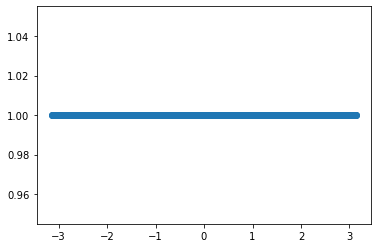

In [7]:
plt.scatter(X, model.predict(X))